In [2]:
import sys
import random
import numpy as np
import seaborn as sns
from scipy.stats import beta
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

In [13]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest_many(funnels, N, num_simulations, simulate_abtest_one, p_crit = 0.05):
    ps = []
    num_winning = 0
    num_significant = 0
    imbalances = []
    for i in range(num_simulations):
        print('Doing simulation run %d...' % i, end='\r')
        observations, funnels_chosen = simulate_abtest_one(funnels, N)
        imbalance = abs(sum(funnels_chosen)/N - 0.5)
        imbalances.append(imbalance)
        p = fisher_exact(observations)[1]
        ps.append(p)
        if p < 0.05:
            num_significant += 1
    print('\nDone!')
    print('Avg imbalance: %.3f' % np.mean(imbalances))
    print('Ratio of stat.sign.: %.3f' % (num_significant/num_simulations))
    print('Histogram of p values:')
    plt.figure(figsize=(10, 5))
    ax = sns.distplot(ps, kde=False, rug=True)
    ax.set(xlabel='p value', ylabel='count')
    plt.show()

Doing simulation run 999...
Done!
Avg imbalance: 0.004
Ratio of stat.sign.: 0.035
Histogram of p values:


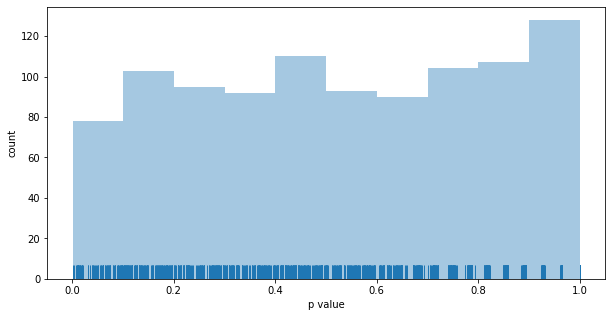

In [16]:
def simulate_abtest_fixed(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    funnels_chosen = []
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnels_chosen.append(which_funnel)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations, funnels_chosen

funnels = [
    [[0.95, 0.05], 0.50], # the first vector is the actual outcomes, the second is the traffic split
    [[0.95, 0.05], 0.50],
]
N = 10*1000
num_simulations = 1000
simulate_abtest_many(funnels, N, num_simulations, simulate_abtest_fixed)

Doing simulation run 999...
Done!
Avg imbalance: 0.368
Ratio of stat.sign.: 0.039
Histogram of p values:


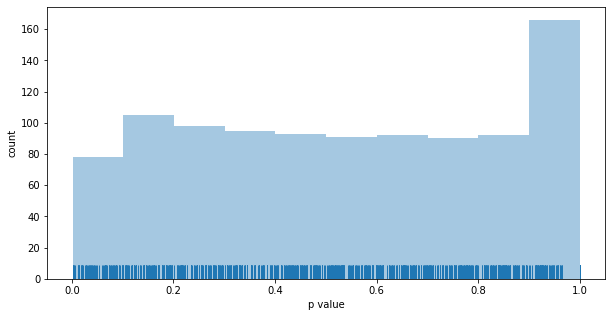

In [17]:
def reward(observation_vector):
    if sum(observation_vector) == 0:
        return 0
    return observation_vector[1] / sum(observation_vector)
    
def simulate_eps_greedy(funnels, N, eps=0.1):
    explore_traffic_split = [1/(len(funnels))] * len(funnels)
    observations = np.zeros([len(funnels), len(funnels[0])])
    rewards = [0] * len(funnels)
    funnels_chosen = []
    for _ in range(N):
        if random.random() < eps:
            # explore, choose one at random
            which_funnel = choice(explore_traffic_split)
        else:
            # exploit, choose the best one so far
            which_funnel = np.argmax(rewards)
        funnels_chosen.append(which_funnel)
        funnel_outcome = choice(funnels[which_funnel])
        observations[which_funnel][funnel_outcome] += 1
        rewards[which_funnel] = reward(observations[which_funnel])
    return observations, funnels_chosen

funnels = [
    [0.95, 0.05],
    [0.95, 0.05]
]
N = 10*1000
num_simulations = 1000
simulate_abtest_many(funnels, N, num_simulations, simulate_eps_greedy)

Doing simulation run 999...
Done!
Avg imbalance: 0.029
Ratio of stat.sign.: 0.054
Histogram of p values:


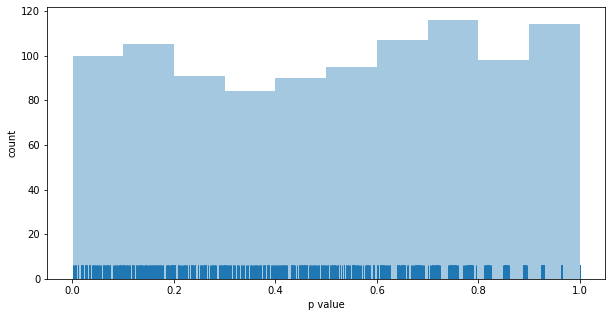

In [18]:
def ucb1_score(reward_funnel, n_funnel, n_total):
    return reward_funnel + np.sqrt(2 * np.log(n_total) / n_funnel)

def simulate_ucb1(funnels, N):
    observations = np.zeros([len(funnels), len(funnels[0])])
    # initially, set each score to a big number, so each funnel goes at least once
    ucb1_scores = [sys.maxsize] * len(funnels)
    funnels_chosen = []
    for n in range(N):
        options = [i for i, score in enumerate(ucb1_scores) if score == max(ucb1_scores)]
        which_funnel = random.choice(options)
        funnels_chosen.append(which_funnel)
        funnel_outcome = choice(funnels[which_funnel])
        observations[which_funnel][funnel_outcome] += 1
        r = reward(observations[which_funnel])
        for i in range(len(funnels)):
            if sum(observations[i]) > 0:
                r = reward(observations[i])
                ucb1_scores[i] = ucb1_score(r, sum(observations[i]), n + 1)
    return observations, funnels_chosen

num_simulations = 1000
simulate_abtest_many(funnels, N, num_simulations, simulate_ucb1)

Doing simulation run 999...
Done!
Avg imbalance: 0.234
Ratio of stat.sign.: 0.090
Histogram of p values:


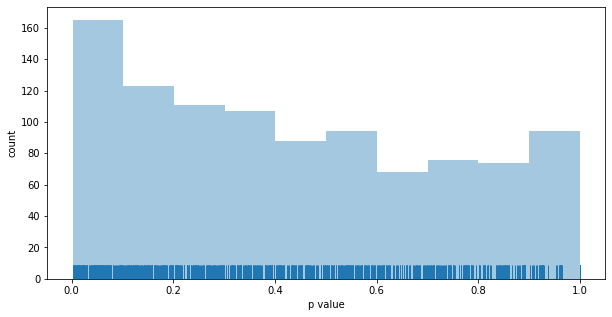

In [20]:
def beta_distributions(observations):
    return [beta(observations[i][1]+1, observations[i][0]+1) for i in range(len(observations))]

def simulate_thompson(funnels, N):
    observations = np.zeros([len(funnels), len(funnels[0])])
    funnels_chosen = []
    for n in range(N):
        betas = beta_distributions(observations)
        p_conv = [beta.rvs(1)[0] for beta in betas]
        which_funnel = np.argmax(p_conv)
        funnels_chosen.append(which_funnel)
        funnel_outcome = choice(funnels[which_funnel])
        observations[which_funnel][funnel_outcome] += 1
    return observations, funnels_chosen

num_simulations = 1000
simulate_abtest_many(funnels, N, num_simulations, simulate_thompson)